In [8]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from scipy import stats
from scipy.signal import detrend
import pandas as pd
import pickle
from scipy import fftpack

proj_dir = '/home/ubuntu/bigStick/antarctic_melting'
data_dir = os.path.join(proj_dir,'data','analysis')
raw_dir = os.path.join(data_dir,'raw')
int_dir = os.path.join(data_dir,'interim')
pro_dir = os.path.join(data_dir,'processed')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')
tab_dir = os.path.join(proj_dir,'reports','tidal_melting','tables')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)
tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

%load_ext autoreload
%autoreload 2

from pySSA.mySSA import mySSA
from log_progress import log_progress
from rotate_vector_roms import rotate_vector_roms
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
def plot_region(tides,no_tides,sel,key):
    
    for k,i in sel.items():
        sel[k] = slice(i.start//2,i.stop//2)
    
    print('subsetting ...')
    t = tides.isel(sel)
    nt = no_tides.isel(sel)
    mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(sel)
    chunks = {'xi_rho':50,'eta_rho':50}
    t = t.chunk(chunks)
    nt = nt.chunk(chunks)
    
    print('processing dyn component ...')
    dyn = ((t.ustar-nt.ustar)*nt.Tstar).where(mask).mean('ocean_time').load()
    print('processing therm component ...')
    therm = ((t.Tstar-nt.Tstar)*nt.ustar).where(mask).mean('ocean_time').load()
    print('processing cov component ...')
    cov = ((t.ustar-nt.ustar)*(t.Tstar-nt.Tstar)).where(mask).mean('ocean_time').load()
    print('processing dMstar ...')
    dMstar = ((t.ustar*t.Tstar).where(mask).mean('ocean_time')-
              (nt.ustar*nt.Tstar).where(mask).mean('ocean_time')).load()
    
    outpath = os.path.join(pro_dir,'dynThermDecomp_'+key+'.nc')
    print('saving results to '+outpath+' ...')
    decomp = xr.Dataset({'dyn':dyn,'therm':therm,'cov':cov,'dMstar':dMstar})
    decomp.to_netcdf(outpath)
    
    print('plotting ... ')
    plot_decomp(decomp)
    
    
def plot_m(ax,da,text,vmin=None,vmax=None):
    total = da.mean()*10000
    da = da *10000
    cmap = ocm.balance
    cmap.set_bad(color='lightgray')
    if vmin == None:
        da.plot(ax=ax,vmin=-da.std()*2,vmax=da.std()*2,cmap=cmap,
                cbar_kwargs={'label': 'u*T* in $10^{-4}$ m/s*degC'})
    else:
        da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,
                cbar_kwargs={'label': 'u*T* in $10^{-4}$ m/s*degC'})

    #ax = make_text(ax,f'mean: {total.values:.2f}'+' $10^{-5}$ m/s*degC)')
    #ax.set_title(f'{text} (mean: {total.values:.2f})')
    ax.set_title(text)
    return ax

def make_text(ax,text):
    ax.text(0.1, 0.1, text, horizontalalignment='center',verticalalignment='center',
                   transform=ax.transAxes)
    return ax

def plot_decomp(decomp,vmin=None,vmax=None,figsize=(8.27,6)):
    fig,axes = plt.subplots(ncols=2,nrows=2,figsize=figsize)
    ax1,ax2,ax3,ax4 = axes.flatten()

    ax1 = plot_m(ax1,decomp.dMstar,'$\overline{u^*_T T^*_T}-\overline{u^*_{NT} T^*_{NT}}$',vmin,vmax)
    ax2 = plot_m(ax2,decomp.therm,'$\overline{u^*_{NT} (T^*_T-T^*_{NT})}$',vmin,vmax)
    ax3 = plot_m(ax3,decomp.dyn,'$\overline{(u^*_T-u^*_{NT}) T^*_T}$',vmin,vmax)
    ax4 = plot_m(ax4,decomp.cov,'$\overline{(u^*_T-u^*_{NT}) (T^*_T-T^*_{NT})}$',vmin,vmax)

    for ax in axes.flatten():
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_facecolor('gray')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1,hspace=0.2)
    plt.savefig(os.path.join(fig_dir,'decomp'+decomp.region+'.png'),format='png',bbox_inches = "tight")
    plt.show()

In [109]:
base_path = os.path.join(raw_dir,'scratch','decomp','regions')
regions = ['FRIS','Shackleton','Ross','GeorgeV','PI','Totten','Amery','Fimbul',
        'LarsenC','Mertz']

ASeas


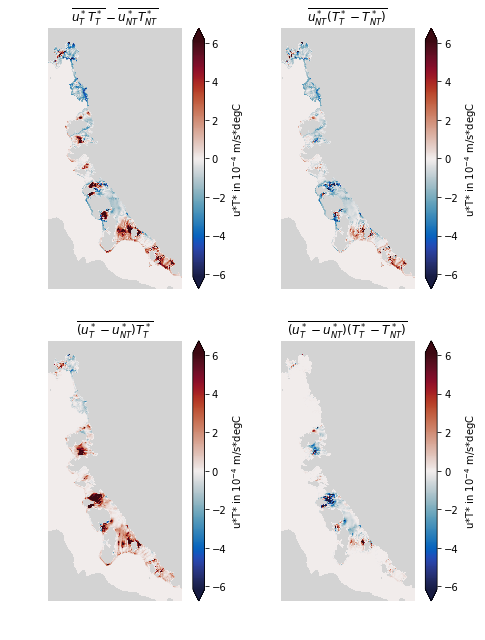

BSeas


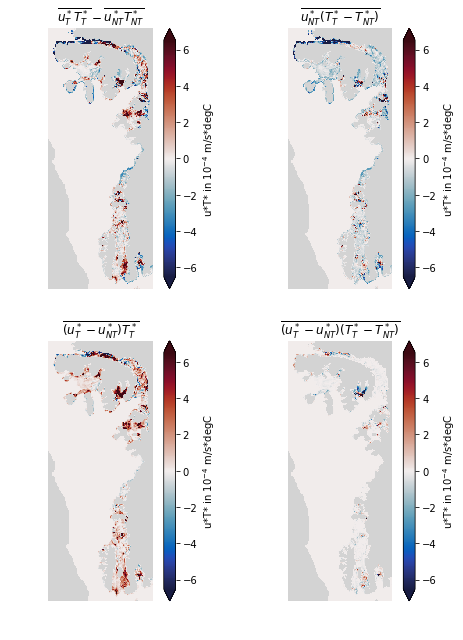

In [110]:
for reg in ['ASeas','BSeas']:
    print(reg)
    decomp = xr.open_dataset(os.path.join(base_path,'decomp'+reg+'.nc'))
    decomp.attrs['region']=reg
    vmax = decomp.dyn.std()*40000
    plot_decomp(decomp,vmin=-vmax,vmax=vmax,figsize=(7,9))

FRIS


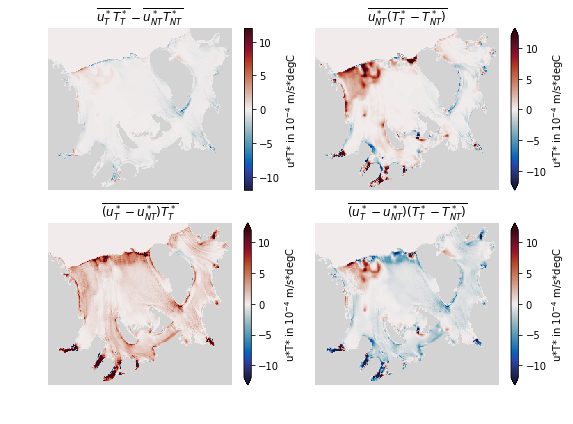

Shackleton


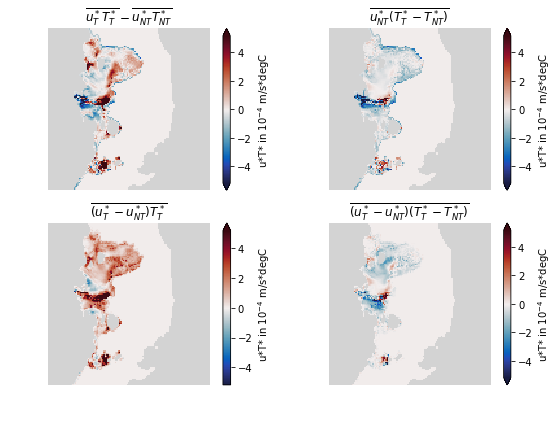

Ross


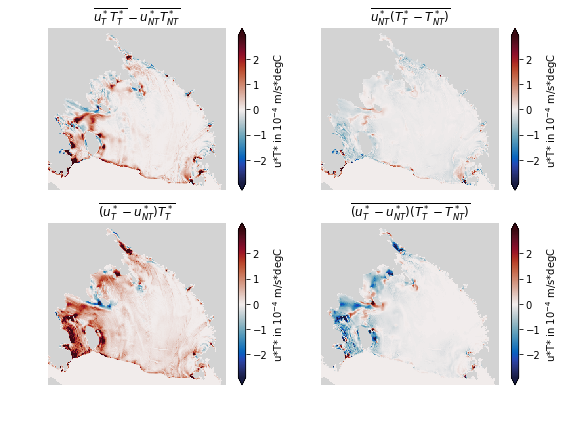

GeorgeV


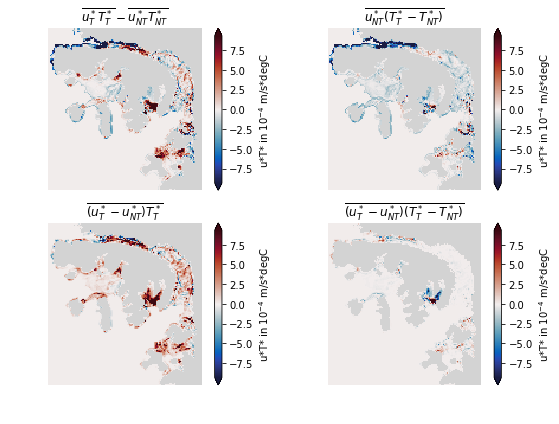

PI


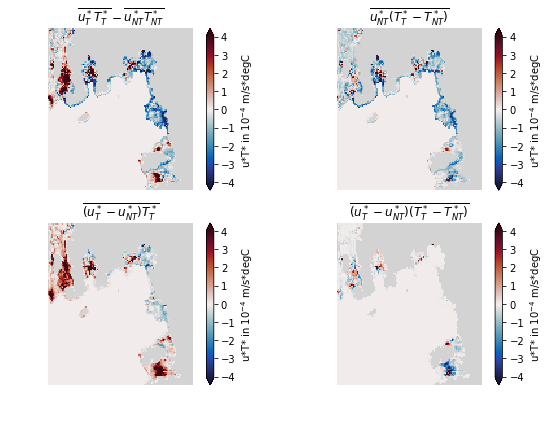

Totten


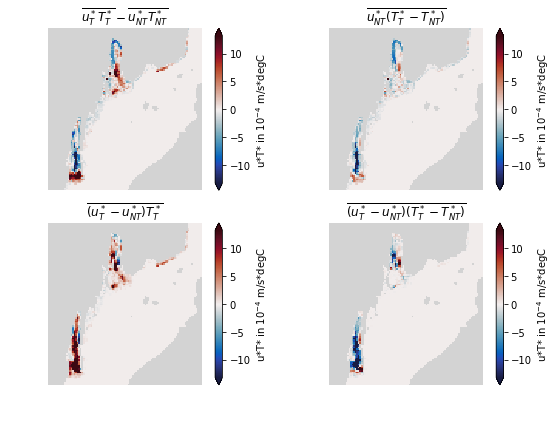

Amery


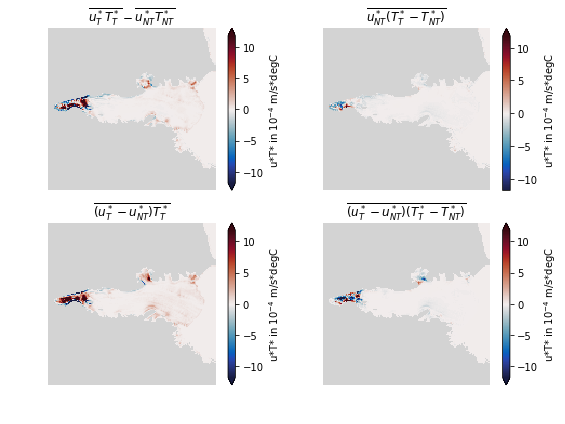

Fimbul


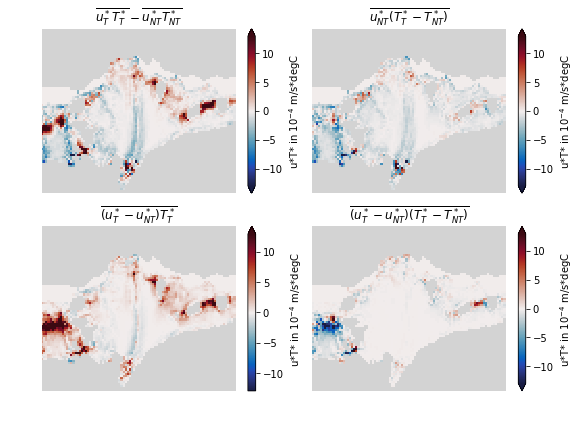

LarsenC


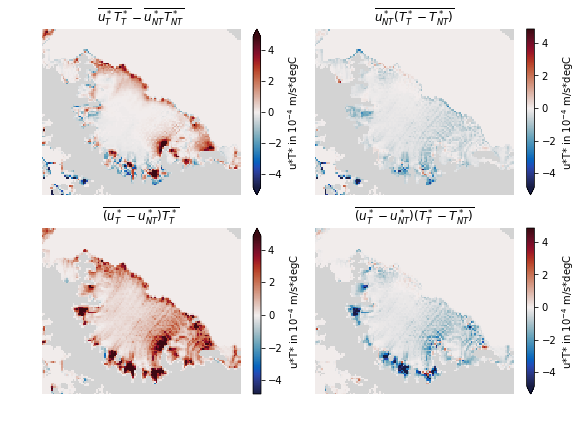

Mertz


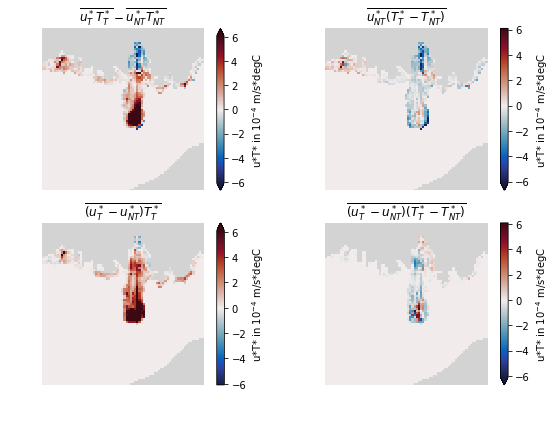

In [111]:
for reg in regions:
    print(reg)
    decomp = xr.open_dataset(os.path.join(base_path,'decomp'+reg+'.nc'))
    decomp.attrs['region']=reg
    vmax = decomp.dyn.std()*40000
    plot_decomp(decomp,vmin=-vmax,vmax=vmax)

In [9]:
file_path = os.path.join(raw_dir,'scratch','waom4','ocean_avg_hr_0010.nc')
tides = xr.open_dataset(file_path)#,chunks={'xi_rho':75,'eta_rho':75})
file_path = os.path.join(raw_dir,'scratch','waom4_nt','ocean_avg_hr_0010.nc')
no_tides = xr.open_dataset(file_path)#,chunks={'xi_rho':75,'eta_rho':75})
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][1050:1140,95:113] = True
mask_shelf['Total Antarctica'][:,1500:] = False

grd.mask_rho[570:610,1030:1140] = False

In [3]:
sel1 = {'xi_rho':slice(714,1243),'eta_rho':slice(1408,1875)} #FRIS
sel2 = {'xi_rho':slice(1185,1726),'eta_rho':slice(652,1146)} #Ross
sel3 = {'xi_rho':slice(380,648),'eta_rho':slice(1114,1780)} #BSeas
sel4 = {'xi_rho':slice(655,924),'eta_rho':slice(720,1244)} #ASeas
sel5 = {'xi_rho':slice(2568,2665),'eta_rho':slice(637,867)} # Totten
sel6 = {'xi_rho':slice(2322,2652),'eta_rho':slice(1650,1781)} # Amery
sel7 = {'xi_rho':slice(1409,1595),'eta_rho':slice(2338,2496)} # Fimbul
sel8 = {'xi_rho':slice(295,534),'eta_rho':slice(1830,2030)} # LarsenC
sel9 = {'xi_rho':slice(390,650),'eta_rho':slice(1500,1775)} # GeorgeV
sel10 = {'xi_rho':slice(550,775),'eta_rho':slice(1000,1250)} # PI
sel11 = {'xi_rho':slice(2550,2750),'eta_rho':slice(650,860)} # Totten
sel12 = {'xi_rho':slice(2330,2640),'eta_rho':slice(1550,1850)} # Amery
sel13 = {'xi_rho':slice(425*5,455*5),'eta_rho':slice(45*5,75*5)} # Mertz
sel14 = {'xi_rho':slice(545*5,595*5),'eta_rho':slice(200*5,250*5)} # Shackleton

sels = {'Shackleton':sel14,'Ross':sel2,'GeorgeV':sel9,'PI':sel10,'Totten':sel11,'Amery':sel12,'Fimbul':sel7,
        'LarsenC':sel8,'Mertz':sel13,'BSeas':sel3}

In [ ]:
from dask.distributed import Client
C = Client()

for k,sel in sels.items():
    print(f'processing {k}')
    plot_region(tides,no_tides,sel,k)

processing Shackleton
subsetting ...
processing dyn component ...


In [ ]:
sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,950),
           'xi_u' : slice(350,649),'eta_u' : slice(700,950),
           'xi_v' : slice(350,650),'eta_v' : slice(700,949)}
FRIS = tides.isel(sel)
FRIS_nt = no_tides.isel(sel)
rho_sel = {'xi_rho' : slice(350,650),'eta_rho' : slice(700,950)}
FRIS_mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(rho_sel)

FRIS = FRIS.chunk(chunks)
FRIS_nt = FRIS_nt.chunk(chunks)

dyn2 = ((FRIS.ustar-FRIS_nt.ustar)*FRIS_nt.Tstar).where(FRIS_mask).mean('ocean_time').load()
print('ping')
therm2 = ((FRIS.Tstar-FRIS_nt.Tstar)*FRIS_nt.ustar).where(FRIS_mask).mean('ocean_time').load()
print('ping')
cov2 = ((FRIS.ustar-FRIS_nt.ustar)*(FRIS.Tstar-FRIS_nt.Tstar)).where(FRIS_mask).mean('ocean_time').load()
print('ping')
dMstar2 = ((FRIS.ustar*FRIS.Tstar).where(FRIS_mask).mean('ocean_time')-
          (FRIS_nt.ustar*FRIS_nt.Tstar).where(FRIS_mask).mean('ocean_time')).load()
print('ping')
dsum2 = (therm2+cov2+dyn2).load()

In [ ]:
fig,axes = plt.subplots(ncols=2,nrows=3,figsize=(12,12))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

ax1 = plot_m(ax1,dMstar2,'dMstar')
ax2 = plot_m(ax2,dsum2,'therm+dyn+cov')
ax3 = plot_m(ax3,therm2,'therm')
ax4 = plot_m(ax4,dyn2,'dyn')
ax5 = plot_m(ax5,cov2,'cov')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [16]:
sel = {'xi_rho' : slice(250,425),'eta_rho' : slice(350,700),
           'xi_u' : slice(250,424),'eta_u' : slice(350,700),
           'xi_v' : slice(250,425),'eta_v' : slice(350,699)}
AB = tides.isel(sel)
AB_nt = no_tides.isel(sel)
rho_sel = {'xi_rho' : slice(250,425),'eta_rho' : slice(350,700)}
AB_mask = ((grd.mask_rho==1) & (mask_shelf['Total Antarctica']==1)).isel(rho_sel)

AB = AB.chunk(chunks)
AB_nt = AB_nt.chunk(chunks)

dyn = ((AB.ustar-AB_nt.ustar)*AB_nt.Tstar).where(AB_mask).mean('ocean_time').load()
print('ping')
therm = ((AB.Tstar-AB_nt.Tstar)*AB_nt.ustar).where(AB_mask).mean('ocean_time').load()
print('ping')
cov = ((AB.ustar-AB_nt.ustar)*(AB.Tstar-AB_nt.Tstar)).where(AB_mask).mean('ocean_time').load()
print('ping')
dMstar = ((AB.ustar*AB.Tstar).where(AB_mask).mean('ocean_time')-
          (AB_nt.ustar*AB_nt.Tstar).where(AB_mask).mean('ocean_time')).load()
print('ping')
dsum = (therm+cov+dyn).load()

KeyboardInterrupt: 

In [ ]:
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(16,8))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

ax1 = plot_m(ax1,dMstar,'dMstar')
ax2 = plot_m(ax2,dsum,'therm+dyn+cov')
ax3 = plot_m(ax3,therm,'therm')
ax4 = plot_m(ax4,dyn,'dyn')
ax5 = plot_m(ax5,cov,'cov')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
plt.tight_layout()
plt.show()